In [1]:
import os
import glob

import numpy as np
import pandas as pd

from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

from utils.utility_functions import jaccard_index

In [2]:
# I/O

# read image patch dataframe
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

seg = main[main['seg'] != -1]
vae = main[main['VAE9_ROT_VIG18'] != -1]

# out dir
out = os.path.join(os.getcwd(), f'output/cluster_overlap')
if not os.path.exists(out):
    os.makedirs(out)

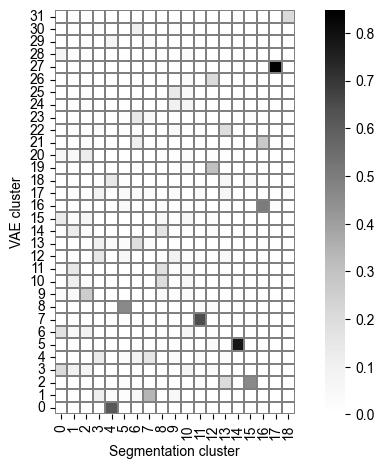

--Call--
> /Users/greg/venvs/vae/lib/python3.9/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 



In [ ]:
# Group cell indices per cluster
seg_dict = {}
for name, group in seg.groupby('seg'):
    seg_dict[name] = group['CellID'].tolist()

vae_dict = {}
for name, group in vae.groupby('VAE9_ROT_VIG18'):
    vae_dict[name] = group['CellID'].tolist()

# Initialize Jaccard Index matrix with zeros
num_clusters_seg = len(seg_dict.keys())
num_clusters_vae = len(vae_dict.keys())
ji_matrix = [[0] * num_clusters_seg for _ in range(num_clusters_vae)] # VAE clusters will comprise matrix rows

# Calculate Jaccard Index for each pair of clusters
for i, j in product(range(num_clusters_vae), range(num_clusters_seg)):
	ji_matrix[i][j] = jaccard_index(vae_dict[i], seg_dict[j])

plot_input = pd.DataFrame(ji_matrix)[::-1]

# Plot
plt.rcParams['font.family'] = 'Arial'
g = sns.heatmap(
    plot_input, cmap='Greys', square=True, linecolor='gray',
    linewidth=0.1, xticklabels=1, yticklabels=1
)
g.set_ylabel('VAE cluster')
g.set_xlabel('Segmentation cluster')
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(out, f'seg-vae_Jaccard_indices.pdf'), bbox_inches='tight')
plt.show()
import pdb; pdb.set_trace()

In [ ]:
heatmap = pd.DataFrame(index=sorted(vae['VAE9_ROT_VIG18'].unique()))

for name, pre_group in sorted(seg.groupby(['seg'])):
    
    post_group = vae[vae['CellID'].isin(pre_group['CellID'])]

    clean_cluster_percents = (
        post_group.groupby(['VAE9_ROT_VIG18']).size() / len(pre_group)
    )

    clean_cluster_pad = clean_cluster_percents.reindex(
        sorted(vae['VAE9_ROT_VIG18'].unique())).fillna(0)

    heatmap[name[0]] = clean_cluster_pad

In [ ]:
# z-scores
heatmap = (heatmap - heatmap.mean()) / heatmap.std()

plt.rcParams['font.family'] = 'Arial'

# HEATMAP CLUSTERING
res = heatmap
clustermap_input = res.fillna(res.min().min())
g = sns.clustermap(
    clustermap_input, xticklabels=1, yticklabels=1, cmap='Greys',linewidths=0.3, linecolor='grey', 
    figsize=(8, 10.5)
)
# g.ax_heatmap.collections[0].colorbar.remove()
# cbar = plt.colorbar(g.ax_heatmap.collections[0], shrink=0.9, pad=0.1)
g.ax_heatmap.set_xlabel('Segmentation-based cluster', fontsize=25, labelpad=6.0)
g.ax_heatmap.set_ylabel('VAE-based cluster', fontsize=25, labelpad=6.0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=15, rotation=0)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=15, rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(out, 'seg-vae_cluster_overlap.pdf'))
plt.show()
plt.close('all')

In [ ]:
# intensity-based clusters contribtuion to total cells in VAE analysis
test = main[main['seg'].isin([4, 5, 11, 14, 15, 17])]
print(f'Intensity-based clusters account for {round(len(test)/len(main)*100)}% of total cells.')